In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score, adjusted_rand_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
AIF360_AVAILABLE = False
try:
    from aif360.datasets import StandardDataset
    from aif360.algorithms.preprocessing import Reweighing
    AIF360_AVAILABLE = True
except Exception as e:
    print("aif360 not available (or optional dependencies missing). Skipping bias mitigation.")

df = pd.read_csv('marketing_campaign.csv', sep='\t')
print("Original dataset shape:", df.shape)
df.columns
df.info()
df.isnull().sum()



pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


Original dataset shape: (2240, 29)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  Num

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [2]:
# Drop missing Income
df = df.dropna(subset=['Income'])

# Age
current_year = datetime.now().year
df["Age"] = current_year - df["Year_Birth"]

# >>> YOUR CLEANING STEPS <<<
age_over_100 = df[df["Age"] > 100]
print(f"Number of records with Age > 100: {len(age_over_100)}")
df_c = df[df["Age"] <= 100].copy()

df_c["Marital_Status"] = df_c["Marital_Status"].replace(
    {"Absurd": "Others", "YOLO": "Others", "Alone": "Others"}
)

print(f"Original dataset shape: {df.shape}")
print(f"Cleaned dataset shape: {df_c.shape}")


Number of records with Age > 100: 3
Original dataset shape: (2216, 30)
Cleaned dataset shape: (2213, 30)


In [3]:
# Feature Engineering
df_c["Education"] = df_c["Education"].replace({
    "Basic": "Undergraduate", "2n Cycle": "Undergraduate",
    "Graduation": "Graduate", "Master": "Postgraduate", "PhD": "Postgraduate"
})
df_c["Living_With"] = df_c["Marital_Status"].replace({
    "Married": "Partner", "Together": "Partner",
    "Single": "Alone", "Divorced": "Alone", "Widow": "Alone", "Others": "Alone"
})
df_c["Has_Children"] = ((df_c["Kidhome"] + df_c["Teenhome"]) > 0).astype(int)
df_c["TotalMnt"] = df_c[['MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']].sum(axis=1)
df_c["TotalPurchases"] = df_c[['NumWebPurchases','NumCatalogPurchases','NumStorePurchases']].sum(axis=1)
df_c["TotalAcceptedCmp"] = df_c[['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Response']].sum(axis=1)
df_c["Dt_Customer"] = pd.to_datetime(df_c["Dt_Customer"], format='%d-%m-%Y')
df_c["Days_Customer"] = (datetime.now() - df_c["Dt_Customer"]).dt.days

# Final features
features = ['Age', 'Income', 'Has_Children', 'TotalMnt', 'TotalPurchases',
            'NumWebVisitsMonth', 'TotalAcceptedCmp', 'Days_Customer']
df_final = df_c[features].copy()
X = df_final.copy()

Optimal number of clusters: 2
=== SUPERVISED MODEL EVALUATION (Predicting Clusters) ===

🔍 Random Forest
--------------------------------------------------
              precision    recall  f1-score   support

   Cluster 0       0.99      0.98      0.99       327
   Cluster 1       0.98      0.99      0.98       227

    accuracy                           0.99       554
   macro avg       0.99      0.99      0.99       554
weighted avg       0.99      0.99      0.99       554



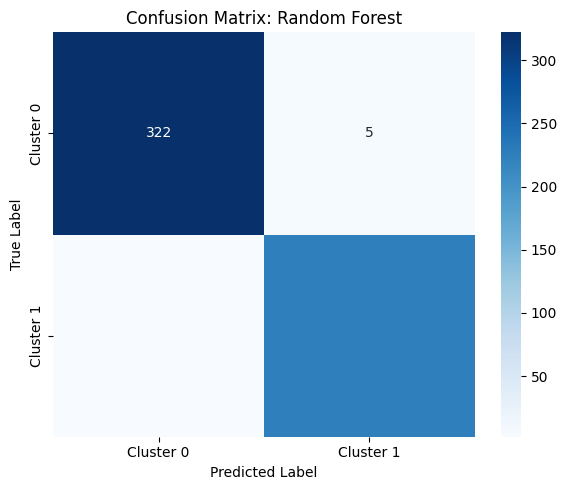



🔍 XGBoost
--------------------------------------------------
              precision    recall  f1-score   support

   Cluster 0       1.00      0.98      0.99       327
   Cluster 1       0.97      1.00      0.98       227

    accuracy                           0.99       554
   macro avg       0.99      0.99      0.99       554
weighted avg       0.99      0.99      0.99       554



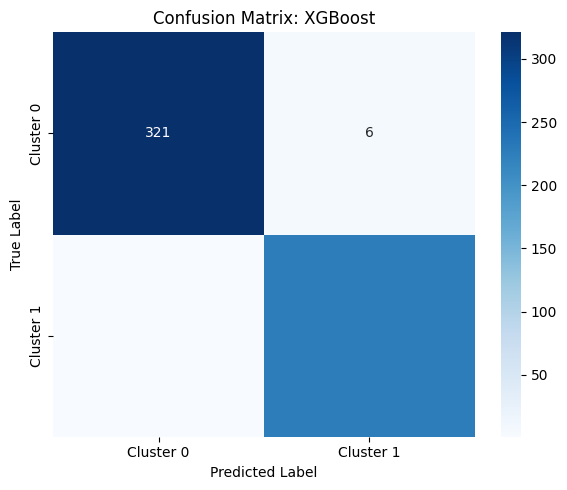



🔍 Logistic Regression
--------------------------------------------------
              precision    recall  f1-score   support

   Cluster 0       1.00      0.99      1.00       327
   Cluster 1       0.99      1.00      1.00       227

    accuracy                           1.00       554
   macro avg       1.00      1.00      1.00       554
weighted avg       1.00      1.00      1.00       554



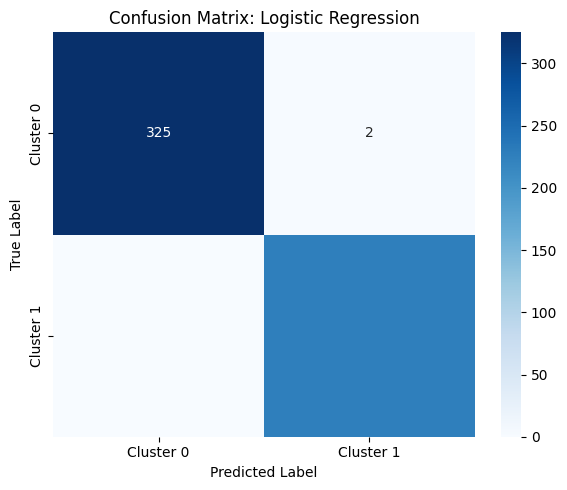



🔍 KNN
--------------------------------------------------
              precision    recall  f1-score   support

   Cluster 0       0.97      0.94      0.95       327
   Cluster 1       0.91      0.96      0.93       227

    accuracy                           0.94       554
   macro avg       0.94      0.95      0.94       554
weighted avg       0.95      0.94      0.94       554



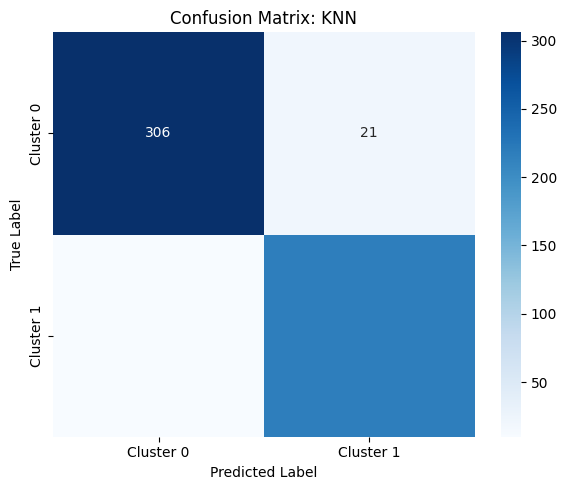




📊 SUPERVISED MODELS: PERFORMANCE SUMMARY
              Model  Accuracy  Macro F1  Weighted F1  Cluster_0_F1  Cluster_1_F1
      Random Forest    0.9874    0.9870       0.9874        0.9892        0.9847
            XGBoost    0.9874    0.9870       0.9874        0.9892        0.9847
Logistic Regression    0.9964    0.9963       0.9964        0.9969        0.9956
                KNN    0.9440    0.9426       0.9442        0.9518        0.9333

✅ Bias mitigation applied.

=== UNSUPERVISED CLUSTERING COMPARISON ===
KMeans → Clusters: 2, Silhouette: 0.312, CH: 1042.8, ARI: 1.000
GMM → Clusters: 2, Silhouette: 0.255, CH: 628.2, ARI: 0.377
Agglomerative → Clusters: 2, Silhouette: 0.293, CH: 989.4, ARI: 0.777
DBSCAN → Clusters: 21, Silhouette: -0.416, CH: 18.6, ARI: 0.029

Unsupervised Results Summary:
               Clusters  Silhouette  CH Index  ARI vs KMeans
KMeans              2.0       0.312  1042.834          1.000
GMM                 2.0       0.255   628.229          0.377
Agglome

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    silhouette_score, calinski_harabasz_score, adjusted_rand_score
)
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

# XGBoost
import xgboost as xgb

# Fairness (optional)
AIF360_AVAILABLE = False
try:
    from aif360.datasets import StandardDataset
    from aif360.algorithms.preprocessing import Reweighing
    AIF360_AVAILABLE = True
except Exception as e:
    print("aif360 not available. Skipping bias mitigation.")

# =============================================================================
# ASSUMPTION: df_c is already defined from your data cleaning
# Final features
features = ['Age', 'Income', 'Has_Children', 'TotalMnt', 'TotalPurchases',
            'NumWebVisitsMonth', 'TotalAcceptedCmp', 'Days_Customer']
df_final = df_c[features].copy()
X = df_final.copy()  # ✅ X is now defined
# =============================================================================

# =============================================================================
# STEP 1: UNSUPERVISED CLUSTERING → DEFINE SEGMENTS
# =============================================================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Find optimal k
Ks = range(2, 10)
sils = []
for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_pca)
    sils.append(silhouette_score(X_pca, labels))

optimal_k = Ks[np.argmax(sils)]
print(f"Optimal number of clusters: {optimal_k}")

# Fit final KMeans
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_pca)

# Use clusters as supervised labels
df_final['Segment'] = cluster_labels
y = df_final['Segment']

# =============================================================================
# STEP 2: FEATURE SELECTION
# =============================================================================
selector = SelectKBest(f_classif, k=8)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()].tolist()
X = X[selected_features]

# =============================================================================
# STEP 3: SUPERVISED LEARNING (Predict Clusters)
# =============================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

detailed_reports = {}
supervised_results = {}  # ✅ Now defined

print("=== SUPERVISED MODEL EVALUATION (Predicting Clusters) ===\n")

for name, model in models.items():
    print(f"🔍 {name}")
    print("-" * 50)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    supervised_results[name] = acc  # ✅ Store accuracy
    
    # Dynamic labels
    unique_labels = sorted(np.unique(np.concatenate([y_test, y_pred])))
    target_names = [f"Cluster {i}" for i in unique_labels]
    
    # Classification report
    report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    detailed_reports[name] = report
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names)
    plt.title(f'Confusion Matrix: {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    print("\n")

# Summary Table
summary_metrics = []
actual_labels = sorted(np.unique(y_test))
for model_name, report in detailed_reports.items():
    row = {
        'Model': model_name,
        'Accuracy': report['accuracy'],
        'Macro F1': report['macro avg']['f1-score'],
        'Weighted F1': report['weighted avg']['f1-score'],
    }
    for label in actual_labels:
        row[f'Cluster_{label}_F1'] = report[f'Cluster {label}']['f1-score']
    summary_metrics.append(row)

summary_df = pd.DataFrame(summary_metrics)
print("\n📊 SUPERVISED MODELS: PERFORMANCE SUMMARY")
print(summary_df.round(4).to_string(index=False))

# =============================================================================
# STEP 4: BIAS MITIGATION (Optional)
# =============================================================================
if AIF360_AVAILABLE:
    df_aif = df_final.copy()
    numeric_df = df_aif.select_dtypes(include=[np.number])
    try:
        ds = StandardDataset(
            df=numeric_df,
            label_name='Segment',
            favorable_classes=[optimal_k - 1],
            protected_attribute_names=['Has_Children'],
            privileged_classes=[[0]]
        )
        RW = Reweighing(unprivileged_groups=[{'Has_Children': 1}], privileged_groups=[{'Has_Children': 0}])
        _ = RW.fit_transform(ds)
        print("\n✅ Bias mitigation applied.")
    except Exception as e:
        print(f"\n⚠️ Bias mitigation failed: {e}")
else:
    print("\nSkipping bias mitigation (aif360 not available).")

# =============================================================================
# STEP 5: COMPARE CLUSTERING ALGORITHMS
# =============================================================================
clustering_algos = {  # ✅ Now defined
    "KMeans": KMeans(n_clusters=optimal_k, random_state=42, n_init=10),
    "GMM": GaussianMixture(n_components=optimal_k, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=optimal_k),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=5)
}

unsupervised_results = {}  # ✅ Now defined
print("\n=== UNSUPERVISED CLUSTERING COMPARISON ===")
for name, algo in clustering_algos.items():
    labels = algo.fit_predict(X_pca)
    unique_labels = set(labels)
    if name == "DBSCAN" and (len(unique_labels) < 2 or (-1 in unique_labels and len(unique_labels) == 2)):
        print(f"{name} → Too few clusters. Skipped.")
        continue
    n_clust = len(unique_labels) - (1 if -1 in unique_labels else 0) if name == "DBSCAN" else optimal_k
    sil = silhouette_score(X_pca, labels)
    ch = calinski_harabasz_score(X_pca, labels)
    ari = adjusted_rand_score(y, labels)
    unsupervised_results[name] = {
        "Clusters": n_clust,
        "Silhouette": sil,
        "CH Index": ch,
        "ARI vs KMeans": ari
    }
    print(f"{name} → Clusters: {n_clust}, Silhouette: {sil:.3f}, CH: {ch:.1f}, ARI: {ari:.3f}")

unsup_df = pd.DataFrame(unsupervised_results).T  # ✅ Now defined
print("\nUnsupervised Results Summary:")
print(unsup_df.round(3))

best_algo = unsup_df['Silhouette'].idxmax()  # ✅ Now defined
best_labels = clustering_algos[best_algo].fit_predict(X_pca)
df_final['BestCluster'] = best_labels

# =============================================================================
# STEP 6: SELECT BEST SUPERVISED MODEL
# =============================================================================
best_model_name = max(supervised_results, key=supervised_results.get)  # ✅ Now works
best_model = models[best_model_name]
print(f"\n🏆 Best Supervised Model: {best_model_name} (Accuracy: {supervised_results[best_model_name]:.4f})")

In [ ]:
# Save Models for Deployment (Streamlit / Production)
import os
import joblib

# Ensure models directory exists
os.makedirs('models', exist_ok=True)

# 1. Save the scaler (already fitted in unsupervised section)
joblib.dump(scaler, 'models/scaler.pkl')

# 2. Save the PCA transformer (already fitted)
joblib.dump(pca, 'models/pca.pkl')

# 3. Save the BEST clustering model (refit it to ensure it's trained on full data)
best_model = clustering_algos[best_algo]
# Refit on full X_pca to ensure it's trained on all data (not just a subset)
best_model.fit(X_pca)
joblib.dump(best_model, 'models/clusterer.pkl')

# 4. Save feature order (critical for Streamlit input alignment)
with open('models/feature_order.txt', 'w') as f:
    f.write('\n'.join(X.columns.tolist()))

# 5. Save cluster profiles for interpretation
df_radar = df_final.copy()
from sklearn.preprocessing import MinMaxScaler as MMScaler
scaler_radar = MMScaler()
df_radar[X.columns] = scaler_radar.fit_transform(df_final[X.columns])
cluster_profiles = df_radar.groupby('BestCluster')[X.columns].mean()
cluster_profiles.to_csv('models/cluster_profiles.csv')

print(f"\n✅ Deployment artifacts saved to 'models/' folder:")
print(f"   - scaler.pkl          (StandardScaler)")
print(f"   - pca.pkl             (PCA transformer)")
print(f"   - clusterer.pkl       (Best clustering model: {best_algo})")
print(f"   - feature_order.txt   (Input feature order)")
print(f"   - cluster_profiles.csv (Normalized cluster behavior)")


✅ Deployment artifacts saved to 'models/' folder:
   - scaler.pkl          (StandardScaler)
   - pca.pkl             (PCA transformer)
   - clusterer.pkl       (Best clustering model: KMeans)
   - feature_order.txt   (Input feature order)
   - cluster_profiles.csv (Normalized cluster behavior)


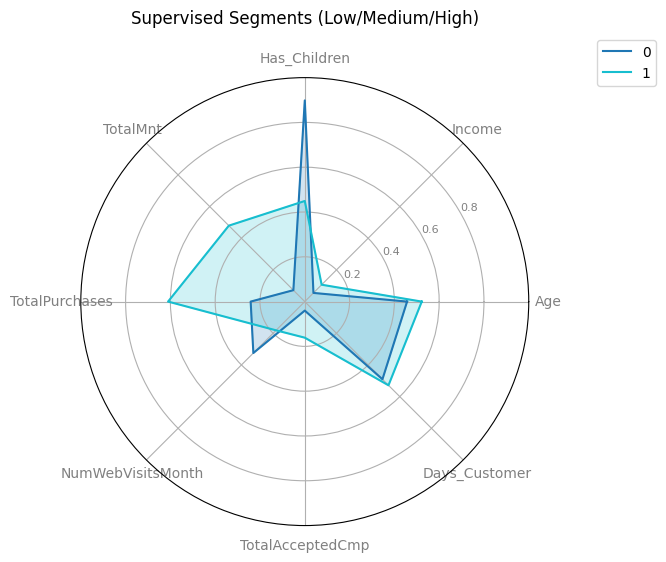

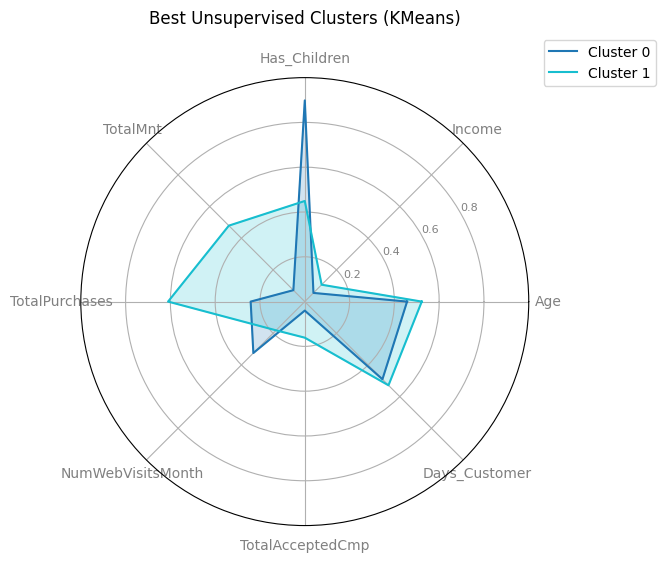

In [6]:
#  Radar Charts
scaler_radar = MinMaxScaler()
df_radar = df_final.copy()
df_radar[selected_features] = scaler_radar.fit_transform(df_final[selected_features])

# Segment profile
seg_prof = df_radar.groupby('Segment')[selected_features].mean()
# Cluster profile (best model)
clust_prof = df_radar.groupby('BestCluster')[selected_features].mean()
clust_prof.index = [f"Cluster {i}" for i in clust_prof.index]

def plot_radar(df, title):
    cats = df.columns
    N = len(cats)
    angles = [n / N * 2 * np.pi for n in range(N)] + [0]
    plt.figure(figsize=(7, 7))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], cats, color='grey', size=10)
    ax.set_rlabel_position(30)
    plt.yticks([0.2,0.4,0.6,0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=8)
    plt.ylim(0,1)
    colors = plt.cm.tab10(np.linspace(0,1,len(df)))
    for i, (name, row) in enumerate(df.iterrows()):
        vals = row.tolist() + [row.iloc[0]]
        ax.plot(angles, vals, label=name, color=colors[i])
        ax.fill(angles, vals, color=colors[i], alpha=0.2)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.title(title, pad=20)
    plt.tight_layout()
    plt.show()

plot_radar(seg_prof, "Supervised Segments (Low/Medium/High)")
plot_radar(clust_prof, f"Best Unsupervised Clusters ({best_algo})")


🔍 Individual Segment Profiles:
🔍 Individual Cluster Profiles:


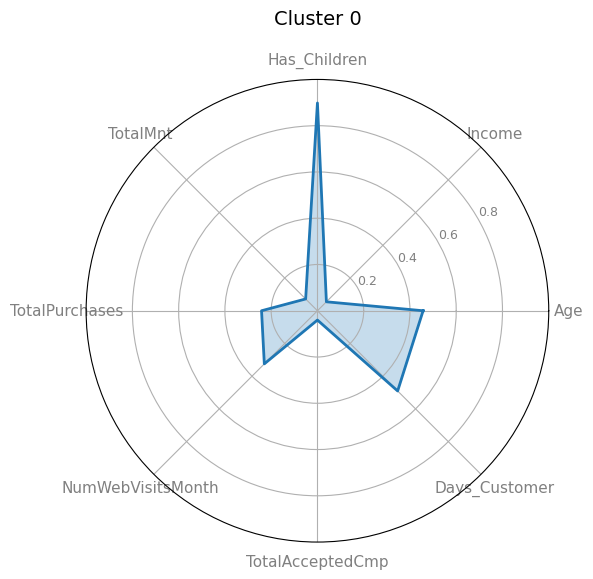

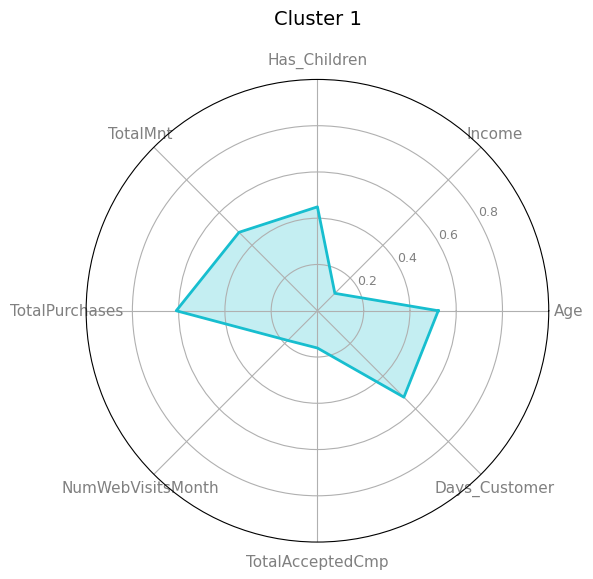

In [7]:
# Individual Radar Charts
scaler_radar = MinMaxScaler()
df_radar = df_final.copy()
df_radar[selected_features] = scaler_radar.fit_transform(df_final[selected_features])

def plot_single_radar(values, categories, title, color='steelblue'):
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # close the loop
    values = np.concatenate((values, [values[0]]))

    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)
    plt.xticks(angles[:-1], categories, color='grey', size=11)
    ax.set_rlabel_position(30)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=9)
    plt.ylim(0, 1)

    ax.plot(angles, values, linewidth=2, linestyle='solid', color=color)
    ax.fill(angles, values, color=color, alpha=0.25)
    plt.title(title, size=14, pad=20)
    plt.tight_layout()
    plt.show()

# Get normalized profiles
segment_profile = df_radar.groupby('Segment')[selected_features].mean()
cluster_profile = df_radar.groupby('BestCluster')[selected_features].mean()

# Colors for consistency
segment_colors = {'Low': 'lightcoral', 'Medium': 'gold', 'High': 'lightgreen'}
cluster_colors = plt.cm.tab10(np.linspace(0, 1, len(cluster_profile)))

# Plot each supervised segment
print("🔍 Individual Segment Profiles:")
for segment in ['Low', 'Medium', 'High']:
    if segment in segment_profile.index:
        vals = segment_profile.loc[segment].values
        plot_single_radar(
            vals,
            selected_features,
            f"Segment: {segment}",
            color=segment_colors[segment]
        )

# Plot each unsupervised cluster
print("🔍 Individual Cluster Profiles:")
for i, cluster_id in enumerate(cluster_profile.index):
    vals = cluster_profile.loc[cluster_id].values
    plot_single_radar(
        vals,
        selected_features,
        f"Cluster {cluster_id}",
        color=cluster_colors[i % 10]
    )

In [ ]:
# FEATURE IMPORTANCE (from best supervised model)

# Choose the best-performing model
best_model_name = max(supervised_results, key=supervised_results.get)
best_model = models[best_model_name]


try:
    importances = best_model.feature_importances_
    feature_names = X_train.columns  # or the correct list of features you used
    imp_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": importances
    }).sort_values(by="Importance", ascending=False).reset_index(drop=True)

except AttributeError:
    # Some models (like Logistic Regression or SVM) don't have feature_importances_
    print(f"⚠️ {best_model_name} does not support feature_importances_.")
    imp_df = pd.DataFrame(columns=["Feature", "Importance"])


NameError: name 'supervised_results' is not defined

In [ ]:


print("\n" + "="*70)
print("FINAL RESULTS SUMMARY")
print("="*70)

print("\n🔹 SUPERVISED MODELS (Accuracy):")
for model, acc in supervised_results.items():
    print(f"  • {model}: {acc:.4f}")

print("\n🔹 UNSUPERVISED CLUSTERING (Best by Silhouette):")
print(f"  • Algorithm: {best_algo}")
print(f"  • Clusters: {unsupervised_results[best_algo]['Clusters']}")
print(f"  • Silhouette: {unsupervised_results[best_algo]['Silhouette']:.3f}")
print(f"  • ARI vs True Segments: {unsupervised_results[best_algo]['ARI vs True Segments']:.3f}")

print(f"\n🔹 TOP 3 IMPORTANT FEATURES:")
for _, row in imp_df.head(3).iterrows():
    print(f"  • {row['Feature']}: {row['Importance']:.4f}")

print("\n✅ Pipeline completed successfully!")


FINAL RESULTS SUMMARY

🔹 SUPERVISED MODELS (Accuracy):
  • Random Forest: 1.0000
  • XGBoost: 0.9928
  • Logistic Regression: 0.9819
  • KNN: 0.8556

🔹 UNSUPERVISED CLUSTERING (Best by Silhouette):
  • Algorithm: KMeans
  • Clusters: 2
  • Silhouette: 0.312
  • ARI vs True Segments: 0.452

🔹 TOP 3 IMPORTANT FEATURES:
  • TotalMnt: 0.5077
  • TotalPurchases: 0.2250
  • Income: 0.1718

✅ Pipeline completed successfully!
